In [31]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd
import glob
import toml

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [32]:
rootdir = "/Users/akshay/research/burrito"
outdirs = ["attempt-2023-09-14"]

In [63]:
def read_toml(cfg):
    c = toml.load(cfg)
    num_lps = len(c['machines']['logparser'])
    c['exp']['logparser']['num'] = num_lps
    return c['exp']

def merge_tomls(cfgs):
    merged_cfg = {}
    for cfg in cfgs:
        for key in cfg:
            if key in merged_cfg:
                if type(cfg[key]) != type(merged_cfg[key]):
                    raise Exception(f"mismatched config types: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == int and merged_cfg[key] != cfg[key]:
                    raise Exception(f"int-valued configs must match: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == list:
                    merged_cfg[key] = list(set(cfg[key]).union(set(merged_cfg[key])))
            else:
                merged_cfg[key] = cfg[key]
    return merged_cfg

tomls = {}
for outdir in outdirs:
    od = f"{rootdir}/{outdir}"
    cfgs = glob.glob(f"{od}/*.toml")
    tomls[outdir] = merge_tomls([read_toml(t) for t in cfgs])

tomls

{'attempt-2023-09-14': {'iterations': 1,
  'pubsub-kafka': [True, False],
  'local-fastpath': [True, False],
  'producer': {'allow-client-sharding': [True],
   'msg-limit': [2500],
   'msg-interarrival-ms': [100],
   'encrypt': ['allow-none']},
  'logingest': {'workers': [2], 'encrypt': ['allow-none']},
  'logparser': {'machines': [1],
   'processes-per-machine': [1],
   'interval-ms': [500],
   'encrypt': ['allow-none'],
   'num': 1},
  'consumer': {'encrypt': ['allow-none']}}}

In [64]:
# copied from elk-app.py
import itertools
def iter_confs(exp, outdir):
    i = exp['iterations']
    prod = exp['producer']
    ing = exp['logingest']
    par = exp['logparser']
    con = exp['consumer']
    confs = itertools.product(
        exp['pubsub-kafka'],
        exp['local-fastpath'],
        prod['allow-client-sharding'],
        prod['msg-limit'],
        prod['msg-interarrival-ms'],
        prod['encrypt'],
        ing['workers'],
        ing['encrypt'],
        par['processes-per-machine'],
        par['interval-ms'],
        par['encrypt'],
        con['encrypt'],
        range(i),
    )
    for conf in confs:
        this_exp = {
                'pubsub-kafka': conf[0],
                'local-fastpath': conf[1],
                'producer': {
                    'allow-client-sharding': conf[2],
                    'msg-limit': conf[3],
                    'msg-interarrival-ms': conf[4],
                    'encrypt': conf[5],
                },
                'logingest': {
                    'workers': conf[6],
                    'encrypt': conf[7],
                },
                'logparser': {
                    'num': par['num'],
                    'processes-per-machine': conf[8],
                    'interval-ms': conf[9],
                    'encrypt': conf[10],
                },
                'consumer': {
                    'encrypt': conf[11],
                },
                'iteration': conf[12],
        }
        template = (
            f"{rootdir}/{outdir}/"
            + "kafka={kafka}-"
            + "localfp={localfp}-"
            + "clshrd={client_shard}-"
            + "nmsg={num_msg}-"
            + "msg_inter_ms={msg_inter_ms}-"
            + "ing_wrk={ingest_workers}-"
            + "par_num={parser_machines}-"
            + "par_pcs={parser_procs}-"
            + "par_rep_int_ms={parser_report_interval_ms}-"
            + "prd_enc={prod_encrypt}-"
            + "ing_enc={ingest_encrypt}-"
            + "par_enc={parser_encrypt}-"
            + "con_enc={consumer_encrypt}-"
            + "i={i}")
        desc = template.format(
            kafka=this_exp['pubsub-kafka'],
            localfp=this_exp['local-fastpath'],
            client_shard=this_exp['producer']['allow-client-sharding'],
            num_msg=this_exp['producer']['msg-limit'],
            msg_inter_ms=this_exp['producer']['msg-interarrival-ms'],
            ingest_workers=this_exp['logingest']['workers'],
            parser_machines=this_exp['logparser']['num'],
            parser_procs=this_exp['logparser']['processes-per-machine'],
            parser_report_interval_ms=this_exp['logparser']['interval-ms'],
            prod_encrypt=this_exp['producer']['encrypt'].replace('-',''),
            ingest_encrypt=this_exp['logingest']['encrypt'].replace('-',''),
            parser_encrypt=this_exp['logparser']['encrypt'].replace('-',''),
            consumer_encrypt=this_exp['consumer']['encrypt'].replace('-',''),
            i=0,
        )
        this_exp['desc'] = desc
        yield this_exp

exps = list(itertools.chain.from_iterable(iter_confs(tomls[outdir], outdir) for outdir in tomls))
list(exps)

[{'pubsub-kafka': True,
  'local-fastpath': True,
  'producer': {'allow-client-sharding': True,
   'msg-limit': 2500,
   'msg-interarrival-ms': 100,
   'encrypt': 'allow-none'},
  'logingest': {'workers': 2, 'encrypt': 'allow-none'},
  'logparser': {'num': 1,
   'processes-per-machine': 1,
   'interval-ms': 500,
   'encrypt': 'allow-none'},
  'consumer': {'encrypt': 'allow-none'},
  'iteration': 0,
  'desc': '/Users/akshay/research/burrito/attempt-2023-09-14/kafka=True-localfp=True-clshrd=True-nmsg=2500-msg_inter_ms=100-ing_wrk=2-par_num=1-par_pcs=1-par_rep_int_ms=500-prd_enc=allownone-ing_enc=allownone-par_enc=allownone-con_enc=allownone-i=0'},
 {'pubsub-kafka': True,
  'local-fastpath': False,
  'producer': {'allow-client-sharding': True,
   'msg-limit': 2500,
   'msg-interarrival-ms': 100,
   'encrypt': 'allow-none'},
  'logingest': {'workers': 2, 'encrypt': 'allow-none'},
  'logparser': {'num': 1,
   'processes-per-machine': 1,
   'interval-ms': 500,
   'encrypt': 'allow-none'},
  

In [67]:
def read_exp(conf):
    outf_prefix = conf['desc']
    suffixes = (
        ["consumer.data", "logingest.data", "producer.data"] 
        + [f'logparser-{i}.data' for i in range(conf["logparser"]['num'])]
    )
    def x():
        for s in suffixes:
            df = pd.read_csv(f"{outf_prefix}-{s}")
            for c in conf:
                if type(conf[c]) == dict:
                    for i in conf[c]:
                        df[f"{c}-{i}"] = conf[c][i]
                else:
                    if c == 'pubsub-kafka':
                        df[c] = 'with-kafka' if conf[c] else 'without-kafka'
                    elif c == 'local-fastpath':
                        df[c] = 'with-fp' if conf[c] else 'without-fp'
                    else:
                        df[c] = conf[c]
            df['machine'] = s.split('.')[0]
            yield df
    return pd.concat(x())

df = pd.concat(read_exp(e) for e in exps)
df

,since_start_us,tot_records,tot_bytes,records,bytes,elapsed_us,rate_records_per_sec,rate_bytes_per_sec,pubsub-kafka,local-fastpath,...,logingest-workers,logingest-encrypt,logparser-num,logparser-processes-per-machine,logparser-interval-ms,logparser-encrypt,consumer-encrypt,iteration,desc,machine
0,8233312,14,0.0,7,0.0,114.0,61041.010839,0.0,with-kafka,with-fp,...,2,allow-none,1,1,500,allow-none,allow-none,0,/Users/akshay/research/burrito/attempt-2023-09...,consumer
1,8233329,21,0.0,7,0.0,55.0,125630.395377,0.0,with-kafka,with-fp,...,2,allow-none,1,1,500,allow-none,allow-none,0,/Users/akshay/research/burrito/attempt-2023-09...,consumer
2,8233414,27,0.0,6,0.0,98.0,60672.248514,0.0,with-kafka,with-fp,...,2,allow-none,1,1,500,allow-none,allow-none,0,/Users/akshay/research/burrito/attempt-2023-09...,consumer
3,8233484,34,0.0,7,0.0,136.0,51456.210765,0.0,with-kafka,with-fp,...,2,allow-none,1,1,500,allow-none,allow-none,0,/Users/akshay/research/burrito/attempt-2023-09...,consumer
4,8233558,41,0.0,7,0.0,175.0,39779.055759,0.0,with-kafka,with-fp,...,2,allow-none,1,1,500,allow-none,allow-none,0,/Users/akshay/research/burrito/attempt-2023-09...,consumer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,46122638,68,0.0,5,0.0,86.0,57906.561972,0.0,without-kafka,without-fp,...,2,allow-none,1,1,500,allow-none,allow-none,0,/Users/akshay/research/burrito/attempt-2023-09...,logparser-0
29,46273329,73,0.0,5,0.0,150716.0,33.174915,0.0,without-kafka,without-fp,...,2,allow-none,1,1,500,allow-none,allow-none,0,/Users/akshay/research/burrito/attempt-2023-09...,logparser-0
30,46618272,76,0.0,3,0.0,345011.0,8.695372,0.0,without-kafka,without-fp,...,2,allow-none,1,1,500,allow-none,allow-none,0,/Users/akshay/research/burrito/attempt-2023-09...,logparser-0
31,46618375,92,0.0,16,0.0,231.0,68996.446683,0.0,without-kafka,without-fp,...,2,allow-none,1,1,500,allow-none,allow-none,0,/Users/akshay/research/burrito/attempt-2023-09...,logparser-0


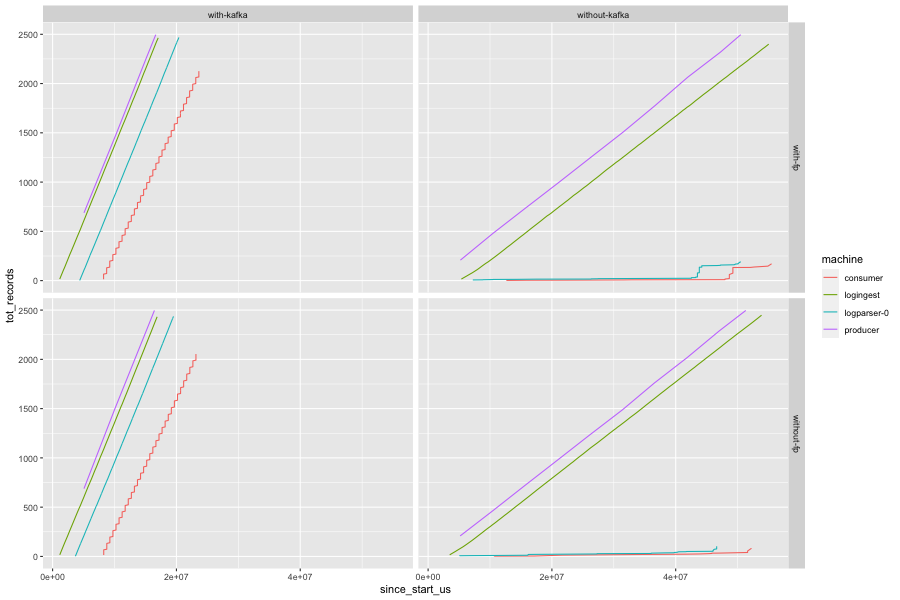

In [69]:
%%R -i df -w 900 -h 600

library(ggplot2)

ggplot(df, aes(x=since_start_us, y=tot_records, colour=machine)) + 
    geom_line() +
    facet_grid(df$"local-fastpath" ~ df$"pubsub-kafka")